In [1]:
from matplotlib import rc

from pathlib import Path
import numpy as np
import os
import xarray as xr
from dask.distributed import Client
import dask.array as da
from collections import OrderedDict               # We often use this to organise our experiments
import haversine
import matplotlib.pyplot as plt
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43969,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:37165,Total threads: 4
Dashboard: /proxy/39019/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:42999,


## Figure out where to put our slice

/home/149/ab8992/.local/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


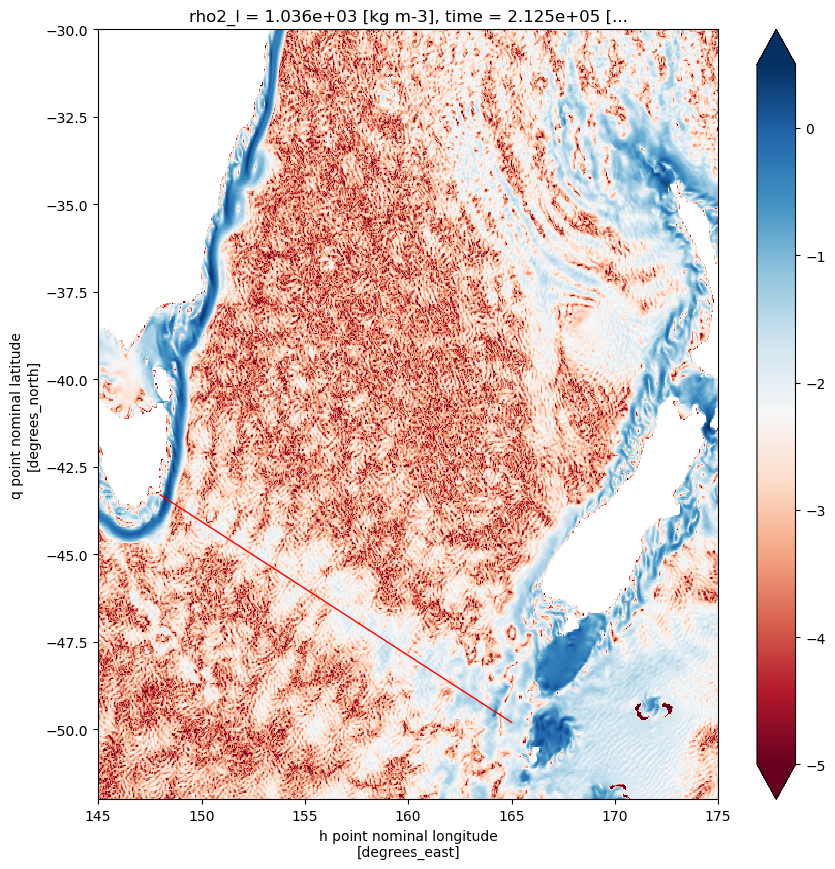

In [24]:
%matplotlib inline

expt = "blank-ttide-20"
movietitle = "hourly_deepspeed-mixed.mp4"


# v = xr.open_mfdataset(f"/g/data/nm03/ab8992/oldruns/blank-ttide-20/outputs/output007/*hourly_v.nc",decode_times = False, parallel = True,chunks = "auto").sel(xh = slice(145,175),yq = slice(-52,-30))
# u = xr.open_mfdataset(f"/g/data/nm03/ab8992/oldruns/blank-ttide-20/outputs/output007/*hourly_u.nc",decode_times = False, parallel = True,chunks = "auto").sel(xq = slice(145,175),yh = slice(-52,-30))

# speed = np.sqrt((v.interp({"yq":u.yh.values}).rename({"yq":"yh"})**2).v + (u.interp({"xq":v.xh.values}).rename({"xq":"xh"})**2).u).isel(time = 50,rho2_l = 5).load()
# e = e.e.isel(time = 50).load()

fig,ax = plt.subplots(1,1,figsize = (10,10))
np.log(speed).plot(ax = ax,vmin = -5,vmax = 0.5,cmap = "RdBu")
ax.plot([148,165],[-43.3,-49.8],color = "red",linewidth = 1)


-66.5713071912546
[-42.10717768709709, 147.24733312407022]


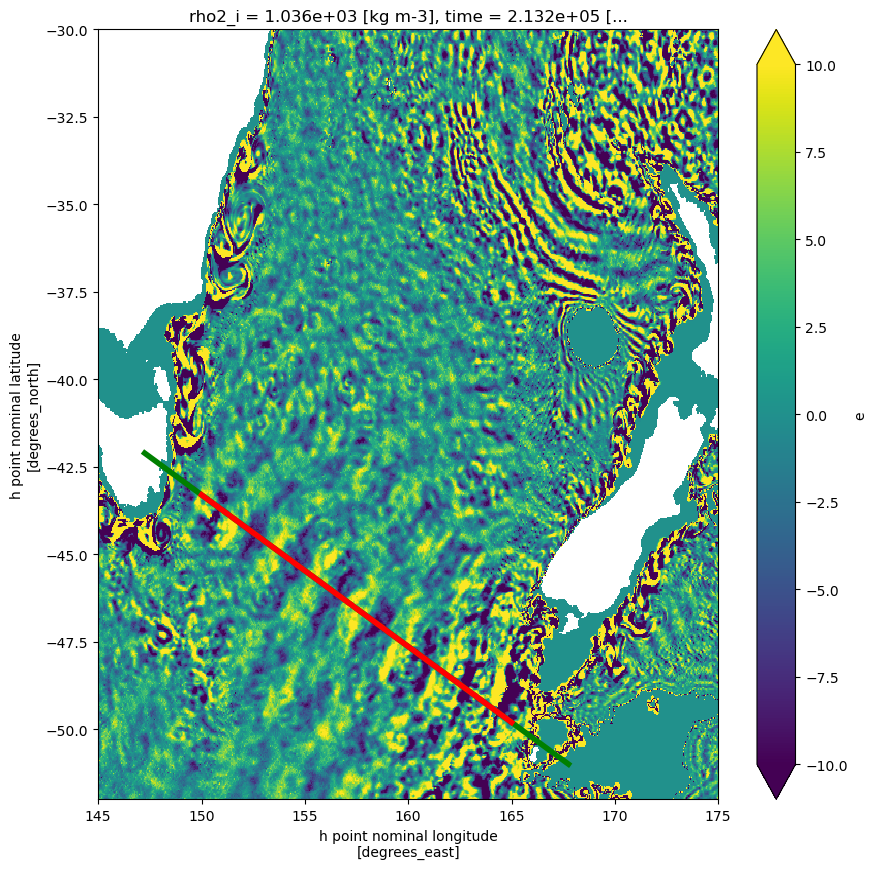

In [11]:
# e = xr.open_mfdataset(f"/g/data/nm03/ab8992/oldruns/blank-ttide-20/outputs/output013/*hourly_e.nc",decode_times = False, parallel = True,chunks = "auto").sel(xh = slice(145,175),yh = slice(-52,-30)).isel(rho2_i = 15).load()

# e_ = (e  - e.mean("time")).isel(time = 50)
A = [-43.3,150]
B = [-49.8,165]
theta = np.arctan((B[1]-A[1])/(B[0]-A[0]))
print(theta / np.pi * 180)
# [150,165],[-43.3,-49.8]
fig,ax = plt.subplots(figsize = (10,10))
C = [3 * np.cos(theta) + A[0],3 * np.sin(theta) + A[1]]
D = [-3 * np.cos(theta) + B[0],-3 * np.sin(theta) + B[1]]
e_.e.plot(ax = ax,vmin = -10,vmax = 10)
ax.plot([C[1],D[1]],[C[0],D[0]],color = "green",linewidth = 4)
ax.plot([150,165],[-43.3,-49.8],color = "red",linewidth = 4)
print(C)

## Drafts of functions to be moved to postprocessing.py




In [3]:
# Calculate bearing between two lat long points
def bearing(lat1,lon1,lat2,lon2):
    """
    Calculates bearing between two lat long points

    Parameters
    ----------
    lat1 : float
        Latitude of first point
    lon1 : float
        Longitude of first point
    lat2 : float
        Latitude of second point
    lon2 : float
        Longitude of second point
    """
    lat1 = lat1 * np.pi / 180
    lat2 = lat2 * np.pi / 180
    lon1 = lon1 * np.pi / 180
    lon2 = lon2 * np.pi / 180
    y = np.sin(lon2-lon1) * np.cos(lat2)
    x = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(lon2-lon1)
    return np.arctan2(y,x) * 180 / np.pi

# function for calculating distance between two lat long points


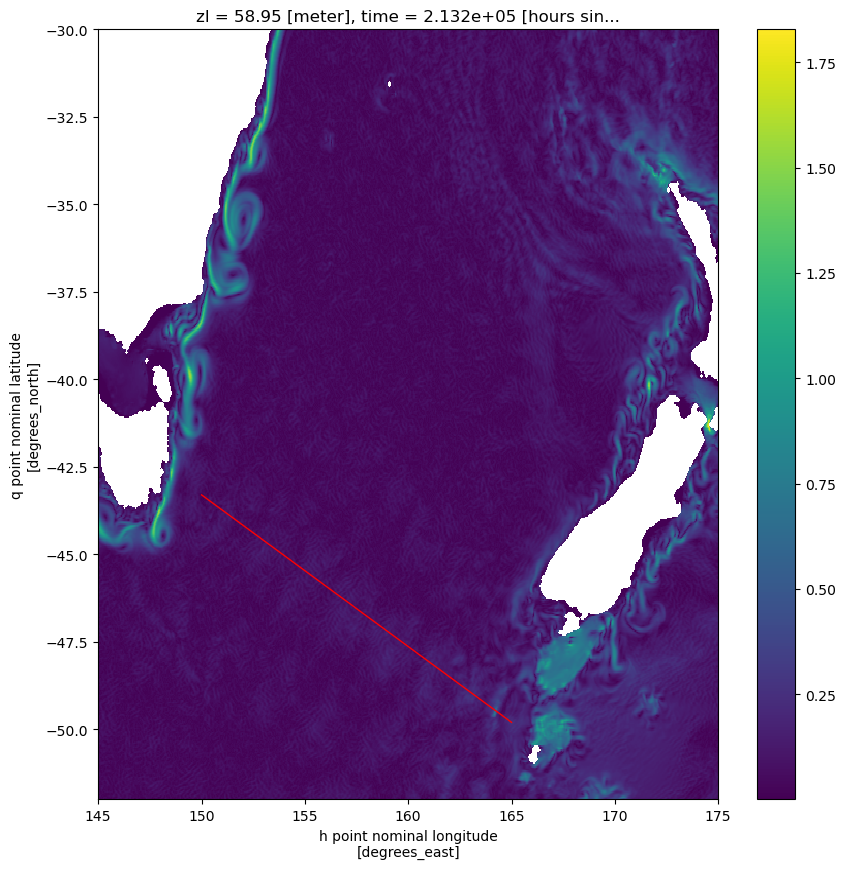

In [206]:
fig,ax = plt.subplots(figsize = (10,10))
speed.plot()
ax.plot([150,165],[-43.3,-49.8],color = "red",linewidth = 1)

## User inputs here

In [107]:

path = Path(f"/g/data/nm03/ab8992/oldruns/{expt}/outputs/output013")

vector = np.array([[148,165],[-41.0,-47.5]])
bwdeg = 5 # width of beam in degrees


theta = bearing(-41.0,148,-47.5,165) ## Angle to horizontal of our beam


## Make our new grid
Need to get the corners of our domain in degrees, then construct our grid in kms. We'll round our domain to the nearest grid point in `xb` and `yb` which are the along beam and against beam coordinates

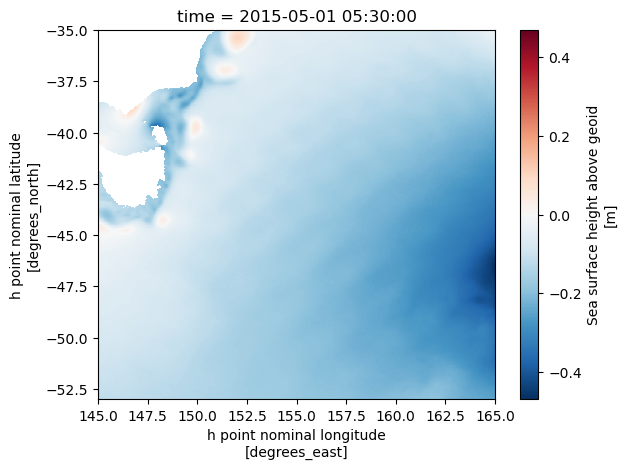

In [138]:
u = xr.open_dataset(path / "20150501.ocean_hourly.nc" ,chunks = "auto").zos.sel(xh = slice(145,165),yh = slice(-53,-35)).isel(time = 5).plot()


## Callum's method

Text(0.5, 1.0, 'Subgrid in latlon')

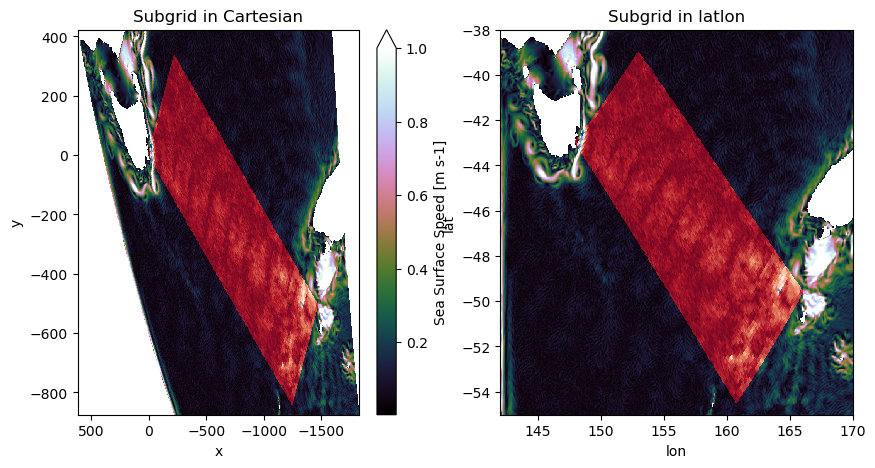

In [182]:
u = xr.open_dataset(path / "20150501.ocean_hourly.nc" ,chunks = "auto").speed.sel(xh = slice(None,170),yh = slice(-55,-38)).isel(time = 5).load()

# lat0,lon0 = -41,148
lon = (u.xh.data)
lat = u.yh.data 

LAT , LON = np.meshgrid(lat,lon)

lat0,lon0 = -43,148

beamwidth_km = 400
beamlength_km = 1500

## Define the original grid on cartesian coordinates
x0,y0 = 6371 * np.cos(lat0 * np.pi/180) * np.sin(lon0 * np.pi/180) , 6371 * np.sin(lat0 * np.pi/180)
# x0,y0 = 0 , R * np.sin(lat0)
# x,y = R * np.cos(LAT) * np.sin(LON), R * np.sin(LAT) - y0
x,y = lonlat_to_xy(LON,LAT,lon0,lat0)

## Define target grid on rotated mesh in km
y_,x_ = np.linspace(0,beamlength_km,100),np.linspace(0,beamwidth_km,100)
X_,Y_ = np.meshgrid(x_,y_)
## Define the rotated grid as represented on the original grid. I.E, the points on x_ y_ as represented on the x,y coordinate system
theta_ = theta * np.pi/180
Xrot , Yrot = X_ * np.cos(theta_) - Y_ * np.sin(theta_) , X_ * np.sin(theta_) + Y_ * np.cos(theta_)

## Calculate X,Y (the rotated grid points) as lat/lon
LONrot,LATrot = xy_to_lonlat(Xrot,Yrot,x0,y0)
# LONrot = 180 - LONrot


u = u.assign_coords(
    {"x":(["xh","yh"],x),
    "y":(["xh","yh"],y)}
)

u = u.rename({"xh":"lon","yh":"lat"})

newgrid = xr.DataArray(
    data = X * 0,
    dims = ["i","j"],
    coords = {
        "x":(["i","j"],Xrot),
        "y":(["i","j"],Yrot),
        "par":(["i"],X_[0,:]),
        "prp":(["j"],Y_[:,0]),
        "lon":(["i","j"],LONrot),
        "lat":(["i","j"],LATrot),
    }
)

regridder = xesmf.Regridder(
    u,newgrid,"bilinear"
)
out = regridder(u,keep_attrs = True)

fig,ax = plt.subplots(1,2,figsize = (10,5))

u.plot(x = "x",y = "y",ax = ax[0],add_colorbar = True,cmap = "cubehelix",vmax = 1)

out.plot(x="x",y = "y",add_colorbar = False,ax = ax[0],cmap = "RdBu",vmax = 1)
ax[0].invert_xaxis()

u.plot(ax = ax[1],add_colorbar = False,cmap = "cubehelix",vmax = 1)

out.plot(x="lon",y = "lat",add_colorbar = False,ax = ax[1],cmap = "RdBu",vmax = 1)

ax[0].set_title("Subgrid in Cartesian")
ax[1].set_title("Subgrid in latlon")


## Turn above into a function

In [28]:
# u = xr.open_dataset(path / "20150501.ocean_hourly.nc" ,chunks = "auto").speed.sel(xh = slice(None,170),yh = slice(-55,-38)).isel(time = 5).load()
import xesmf
# lat0,lon0 = -41,148


lat0,lon0 = -43,148

beamwidth_km = 400
beamlength_km = 1500
def xy_to_lonlat(x,y,x0,y0):
    """
    All outputs are in degrees
    """
    lat = np.arcsin((y + y0) / 6371)
    lon = np.arcsin((x + x0) / (6371 * np.cos(lat)))
    #! HARDCODED FOR QUADRANT 2
    lon = np.pi - lon
    return lon * 180 / np.pi,lat * 180 / np.pi

def lonlat_to_xy(lon,lat,lon0,lat0):
    """
    All inputs are in degrees
    """
    R = 6371
    lon /= 180 / np.pi
    lat /= 180 / np.pi
    lon0 /= 180 / np.pi
    lat0 /= 180 / np.pi
    x0,y0 = R * np.cos(lat0) * np.sin(lon0) , R * np.sin(lat0)
    x,y = R * np.cos(lat) * np.sin(lon) - x0, R * np.sin(lat) - y0



    return x,y
def beamgrid(data,lat0 = -42.1,lon0 = 147.2,beamwidth = 400,beamlength = 1500,plot = False,xname = "xh",yname = "yh",vmin = None,vmax = None):
    # make a docstring describing these variables
    """
    data : xarray.DataArray
        The data to be gridded
    lat0 : float
        Latitude of the origin of the beam
    lon0 : float
        Longitude of the origin of the beam
    beamwidth : float
        Width of the beam in km
    beamlength : float
        Length of the beam in km
    res : float
        Resolution of the grid in km
    plot : bool
        Whether to plot the grid. If plotting, only pass dataarray

    Return a xarray.DataArray cut down to size on to the beam grid. The resolution is automatically determined from the base grid.

    """

    if plot == True:
        assert isinstance(data,xr.DataArray), "Data must be an xarray.DataArray"


    lon = (data.xh.data)
    lat = data.yh.data 
    theta = np.arctan((-43.3 + 49.8) / -17) #! Hardcoded. This comes out to -20.9 degrees
    theta *= -1 ## Look, I just did some trial and error until the beam was in the right quadrant. Who needs year 10 maths
    res = haversine.haversine((lat[0],lon[0]),(lat[0],lon[1]))
    LAT , LON = np.meshgrid(lat,lon)

    ## Define target grid on rotated mesh in km
    y_ = np.linspace(
        -0.5 * beamwidth,
        0.5 * beamwidth,
        int(beamwidth // res))
    x_ = np.linspace(
        0,
        -1 * beamlength,
        int(beamlength // res))
    
    X_,Y_ = np.meshgrid(x_,y_)
    ## Define the rotated grid as represented on the original grid. I.E, the points on x_ y_ as represented on the x,y coordinate system
    theta_ = theta
    Xrot , Yrot = X_ * np.cos(theta_) - Y_ * np.sin(theta_) , X_ * np.sin(theta_) + Y_ * np.cos(theta_)
    ## Calculate X,Y (the rotated grid points) as lat/lon
    x0,y0 = 6371 * np.cos(lat0 * np.pi/180) * np.sin(lon0 * np.pi/180) , 6371 * np.sin(lat0 * np.pi/180)
    LONrot,LATrot = xy_to_lonlat(Xrot,Yrot,x0,y0)

    ## Create target grid to interpolate onto
    newgrid = xr.DataArray(
        data = X_ * 0,
        dims = ["i","j"],
        coords = {
            "xb":(["j"], - X_[0,:]), ## This sets the coordinate as running from Tasmania -> Mac ridge
            "yb":(["i"],Y_[:,0]),
            "lon":(["i","j"],LONrot),
            "lat":(["i","j"],LATrot),
        }
    )

    regridder = xesmf.Regridder(
    data.rename({"xh":"lon","yh":"lat"}),newgrid,"bilinear"
    )

    out = regridder(
        data.rename({xname:"lon",yname:"lat"}),keep_attrs = True
        )
    # assign attributes to out
    out.attrs = data.attrs
    out.attrs["Description"] = f"Beamwidth {beamwidth}km, Beamlength {beamlength}km, Resolution {res}km, angle {theta} degrees, origin {lat0,lon0}"
    out.xb.attrs = {
        "Description": {
            "long_name": "Distance along beam from Tasmania towards Macquarie Ridge",
            "units": "km",
        }
    }
    out.yb.attrs = {
        "Description": {
            "long_name": "Distance perpendicular to beam referened from beam centre",
            "units": "km",
        }
    }
    out.lon.attrs = {
        "Description": {
            "long_name": "Longitude of grid point",
            "units": "degrees",
        }
    }
    out.lat.attrs = {
        "Description": {
            "long_name": "Latitude of grid point",
            "units": "degrees",
        }
    }

    if plot == False:
        return out

    else:
        out = out.assign_coords(
            {"x":(["i","j"],Xrot),
             "y":(["i","j"],Yrot)}
        )

        ## Define the original grid on cartesian coordinates
        x,y = lonlat_to_xy(LON,LAT,lon0,lat0)


        toplot = data.assign_coords(
            {"x":(["xh","yh"],x),
            "y":(["xh","yh"],y)}
        )

        fig,ax = plt.subplots(1,2,figsize = (14,7))

        toplot.plot(x = "x",y = "y",ax = ax[0],add_colorbar = False,cmap = "cubehelix",vmax = vmax,vmin = vmin)

        out.plot(x="x",y = "y",add_colorbar = False,ax = ax[0],cmap = "RdBu",vmax = vmax,vmin = vmin)
        ax[0].invert_xaxis()

        toplot.plot(ax = ax[1],add_colorbar = False,cmap = "cubehelix",vmax = vmax,vmin = vmin)

        out.plot(x="lon",y = "lat",add_colorbar = False,ax = ax[1],cmap = "RdBu",vmax = vmax,vmin = vmin)

        ax[0].set_title("Subgrid in Cartesian")
        ax[1].set_title("Subgrid in latlon")

        return out
    

# out = beamgrid(u,-43,148,plot = True)
# out = beamgrid(e_.e,-42.1,147.2,plot = True,vmin = -10,vmax = 10,beamlength = 1700)


<xarray.DataArray 'e' (i: 116, j: 496)>
array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-10.541606  ,  -6.4491315 ,   0.39415202, ...,   0.        ,
          0.        ,   0.        ],
       [-14.710919  ,  -9.313812  ,  -1.9082199 , ...,   0.        ,
          0.        ,   0.        ],
       [-17.857122  , -16.307644  , -16.171198  , ...,   0.        ,
          0.        ,   0.        ]], dtype=float32)
Coordinates:
    rho2_i   float64 1.036e+03
    time     float64 2.132e+05
    xb       (j) float64 -0.0 3.434 6.869 10.3 ... 1.693e+03 1.697e+03 1.7e+03
    yb       (i) float64 -200.0 -196.5 -193.0 -189.6 ... 189.6 193.0 196.5 200.0
    lat      (i, j) float64 -44.41 -44.42 -44.44 -44.45 ... -47.39 -47.41 -47.43
    lon      (i, j) float64 144.7 144.7 144.7 144.8 ... 167.8 167.8 167.9 167.9
Dimensions without coordinates: i, j
Attributes:
    Description:  Beamwidth 400km, Beamlength 1700km, Resolution 3.4243688480...

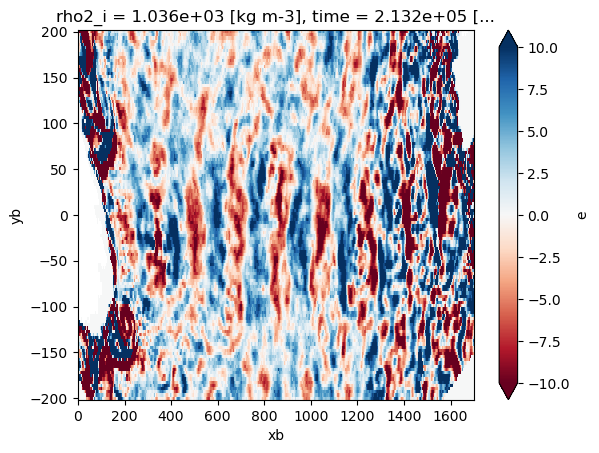

In [29]:
out = beamgrid(e_.e,-42.1,147.2,plot = False,vmin = -10,vmax = 10,beamlength = 1700)
out.plot(x = "xb",y = "yb",vmin = -10,vmax = 10,cmap = "RdBu")
out

In [9]:
angle = np.arctan((-43.3 + 49.8) / -17)
print(angle * 180 / np.pi)
theta = bearing(-43.3,148,-49.8,165) ## Angle to horizontal of our beam

print(theta )

-20.92450174492117
125.08282964942806


In [41]:
e.e

<xarray.DataArray 'e' (time: 120, yh: 583, xh: 600)>
array([[[-563.25037, -564.3365 , -564.6243 , ..., -588.4646 ,
         -582.74585, -580.9711 ],
        [-560.8328 , -565.65485, -573.6133 , ..., -585.0516 ,
         -586.0921 , -588.2168 ],
        [-567.5576 , -570.4555 , -566.75214, ..., -584.04926,
         -584.7733 , -582.0546 ],
        ...,
        [       nan,        nan,        nan, ..., -580.6952 ,
         -566.8834 , -563.1058 ],
        [       nan,        nan,        nan, ..., -578.3271 ,
         -567.01056, -561.1437 ],
        [       nan,        nan,        nan, ..., -564.20624,
         -558.1658 , -559.5498 ]],

       [[-563.72797, -565.10016, -565.6603 , ..., -589.37445,
         -585.2423 , -584.256  ],
        [-561.235  , -566.5404 , -575.76434, ..., -586.63696,
         -588.96216, -590.9161 ],
        [-568.3919 , -571.7738 , -568.40704, ..., -586.04443,
         -587.1729 , -585.0766 ],
...
        [       nan,        nan,        nan, ..., -563.21515,
         -564.6332 , -564.7831 ],
        [       nan,        nan,        nan, ..., -580.23834,
         -573.35187, -563.65533],
        [       nan,        nan,        nan, ..., -593.7851 ,
         -588.26807, -573.07294]],

       [[-565.92664, -573.82587, -585.9129 , ..., -587.2063 ,
         -590.06354, -590.22015],
        [-565.3887 , -571.34827, -588.5859 , ..., -583.1428 ,
         -581.5718 , -580.74677],
        [-569.3575 , -569.4992 , -568.4647 , ..., -587.28815,
         -585.6616 , -584.7584 ],
        ...,
        [       nan,        nan,        nan, ..., -564.7693 ,
         -566.028  , -565.36206],
        [       nan,        nan,        nan, ..., -582.65857,
         -575.3497 , -565.1393 ],
        [       nan,        nan,        nan, ..., -594.5689 ,
         -588.1825 , -574.4109 ]]], dtype=float32)
Coordinates:
  * xh       (xh) float64 145.0 145.1 145.1 145.2 ... 174.8 174.9 174.9 175.0
  * yh       (yh) float64 -51.98 -51.94 -51.91 -51.87 ... -30.09 -30.06 -30.02
    rho2_i   float64 1.036e+03
  * time     (time) float64 2.131e+05 2.131e+05 ... 2.132e+05 2.132e+05
Attributes:
    units:         m
    long_name:     Interface Height Relative to Mean Sea Level
    cell_methods:  area:mean rho2_i:point yh:mean xh:mean time: point